In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fld = "D:/Storage/datasets/first-break-recognition-dataset/data"
file_name = r"df.parquet.gzip"
df = pd.read_parquet(os.path.join(fld, file_name))
df.head()

,data_array,rec_coord,shot_id,sample_rate,spare1,shot_id_split_indices,data_array_shape
0,"[0.0009000493, 0.021326812, -0.001981188, 0.00...","[698463, 5245981]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[652, -1, 640, -1, 624, 608, 598, 594, 590, 58...","[0, 46]","[751, 46]"
1,"[0.00025968463, 0.001776692, 0.001177756, -0.0...","[698463, 5245981]","[20221271, 20241007, 20241011, 20241014, 20241...",2000,"[400, 324, 322, 328, 328, 332, 340, 332, 334, ...","[46, 93]","[751, 47]"
2,"[-2.206082e-05, 7.367933e-05, 0.00034438886, 0...","[698463, 5245981]","[20241142, 20261130, 20261132, 20261135, 20261...",2000,"[614, 592, 584, 574, 562, 552, 544, 534, 526, ...","[93, 140]","[751, 47]"
3,"[0.0012893621, -0.0004232443, 0.0013825478, 0....","[698463, 5245981]","[20261255, 20281005, 20281009, 20281015, 20281...",2000,"[256, 184, 182, 188, 192, 194, 194, 204, 214, ...","[140, 183]","[751, 43]"
4,"[0.005283858, -0.0003585693, -0.0001478088, -0...","[698463, 5245981]","[20281122, 20301134, 20301137, 20301140, 20301...",2000,"[568, 546, 538, 526, 516, 506, 498, 488, 478, ...","[183, 226]","[751, 43]"


In [3]:
# reshaping
df["data_array"] = df.apply(lambda row: row["data_array"].reshape(row["data_array_shape"]), axis=1)

In [4]:
i = 5
x = df["data_array"][i] ** 2.0

window_size_ms = 30.0
window_size = int(window_size_ms / df["sample_rate"][i] * 1e3)
window = np.ones(window_size)
print(f"Window size: {window_size_ms}ms; Number of points: {window_size}")

Window size: 30.0ms; Number of points: 15


In [5]:
accumulated_energy = np.vstack([np.convolve(xi, window, mode="same") for xi in x.T]).T
energy_ratio = accumulated_energy[window_size:] / (accumulated_energy[:-window_size] + 1e-6)

time = 1e-3 * np.arange(df["data_array"][i].shape[0]) * df["sample_rate"][i]
spare1_recognized = time[np.argmax(energy_ratio, axis=0) + window_size]

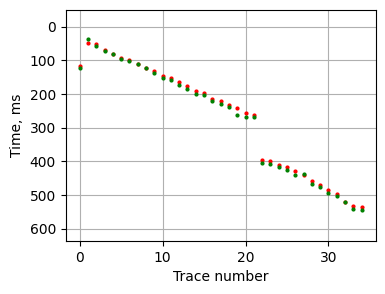

In [6]:
x = np.arange(df["data_array"][i].shape[1], dtype=int)
y = 1e-3 * np.arange(df["data_array"][i].shape[0]) * df["sample_rate"][i]
X, Y = np.meshgrid(x, y)
spare1 = df["spare1"][i]
eps = 1e-6

plt.figure(figsize=(4, 3))
plt.plot(x[spare1 > eps], spare1[spare1 > eps], ".r", ms=4)
plt.plot(x, spare1_recognized, ".g", ms=4)
plt.ylabel("Time, ms")
plt.ylim(np.min(spare1[spare1 > eps]) - 100.0, np.max(spare1[spare1 > eps]) + 100.0)
plt.gca().invert_yaxis()
plt.xlabel("Trace number")
plt.grid()
plt.show()

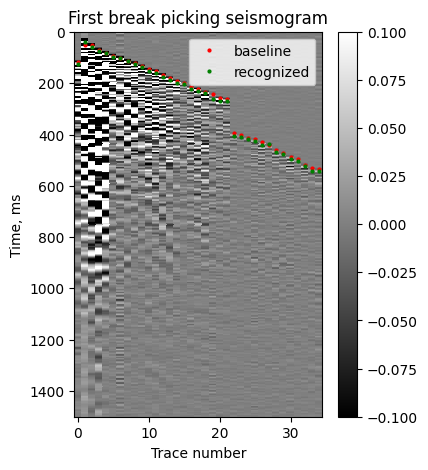

In [7]:
plt.figure(figsize=(4, 5))
plt.pcolor(X, Y, df["data_array"][i], cmap="gray", clim=(-0.1, 0.1))
plt.plot(x[spare1 > eps], spare1[spare1 > eps], ".r", ms=4, label="baseline")
plt.plot(x, spare1_recognized, ".g", ms=4, label="recognized")
plt.gca().invert_yaxis()
plt.ylabel("Time, ms")
plt.xlabel("Trace number")
plt.title("First break picking seismogram")
plt.colorbar()
plt.legend()
plt.show()